# Алешко Альберт   
# АС-21-05   
# Вариант 1

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from math import *
import pandas as pd
from functools import partial
plt.style.use('Solarize_Light2')

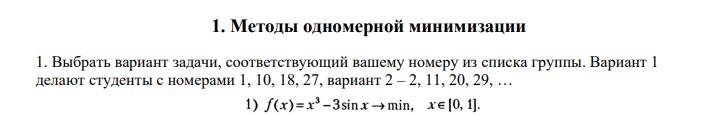

In [59]:
def func(x):
    return x**3 - 3 * sin(x)

def deriv1(x):
    return 3*x**2 - 3*cos(x)

def deriv2(x):
    return 6*x + 3 * sin(x)

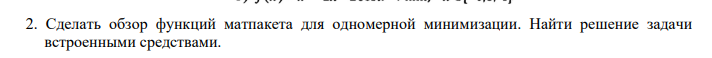

### Функция minimize библиотеки scipy

Функция minimize принимает на вход вызываемую функцию, метод, начальную точку, а так же ряд других аргументов, при необходимости...

На выходе мы получаем сообщение о том как завершилась работа функции, № ошибки (при успехе 0), значение функции, значение переменной, кол-во итераций, и число просчитываний функции.

In [60]:
f = np.vectorize(func)
minimum = scipy.optimize.minimize(f,method='Powell',bounds=scipy.optimize.Bounds(0,1),x0=0.2)
minimum

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -1.6421304129142102
       x: [ 8.241e-01]
     nit: 2
   direc: [[ 3.015e-14]]
    nfev: 54

### Функция brent

Делает то же что и minimize, только вычисляет каким-то одним методом, поэтому параметров меньше. На вход, помимо функции и интервала, указание на полноту вывода и максимальное кол-во итераций. 

В полном выводе возращает переменную, значение функции, кол-во итераций и кол-во вычислений функции.

In [61]:
minimal_brent = scipy.optimize.brent(func, brack = (0,1), full_output = True)
minimal_brent

(0.8241323111380852, -1.6421304129142098, 10, 13)

Визуализация функции на заданном интервале с ответом, полученным встроенными методами.

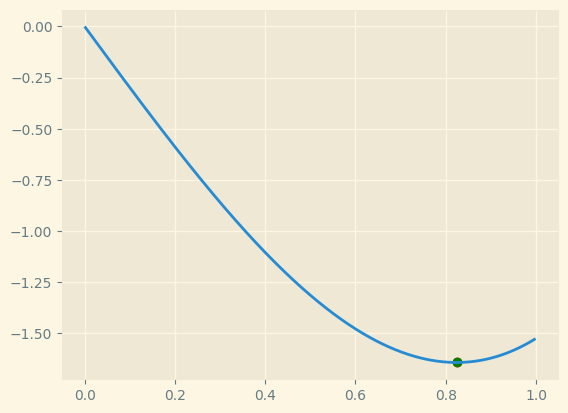

In [62]:
x = np.arange(0, 1, 0.001)
plt.plot(x, f(x))
plt.scatter(minimum['x'], minimum['fun'], color = 'red')
plt.scatter(minimal_brent[0], minimal_brent[1], color = 'green')
plt.grid(True)

Функции отвечающие за построение траектории решения.

In [63]:
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param x_steps: np.array(float) — шаги алгоритма по оси Ox
    :param y_steps: np.array(float) — шаги алгоритма по оси Оу
    :param ax: холст для отрисовки графика
    :param grid: np.array(float) — точки отрисовки функции func
    :param title: str — заголовок графика
    """
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i],
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i],
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

In [64]:
class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска.
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

In [65]:
def plotting(axes, i, answer, title):
    if axes is not None:
        ax = axes[np.unravel_index(i, shape=axes.shape)]
        x_steps = np.array(callback.x_steps)
        y_steps = np.array(callback.y_steps)
        plot_convergence_1d(
            f, x_steps, y_steps,
            ax, grid, title
        )
        ax.axvline(answer, 0, linestyle="--", c="red",
                    label=f"true answer = {answer}")
        ax.axvline(x_steps[-1], 0, linestyle="--", c="xkcd:tangerine",
                    label=f"estimate = {np.round(x_steps[-1], 3)}")
        ax.legend(fontsize=16)

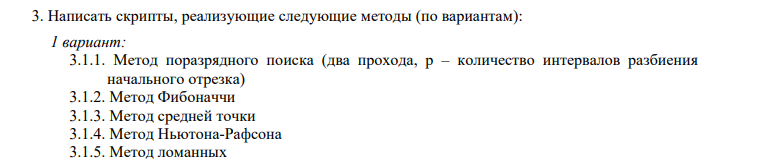
### Метод поразрядного поиска

Сначала шаг равен (b-a)/p, потом eps, в начале вычисляется значения функции в 2 точках, потом на каждой итерации только один раз в последующих точках.

In [66]:
def bitwise_method(fun,a,b,p = 100,eps = 10**-6, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
    count = 2
    
    h = (b-a)/p
    x = a
    f0 = fun(x)
    f1 = fun(x+h)
    
    callback(x,f0)
    
    x+=h
    while(f1 < f0 and x < b):
#         print(f1,f0, x+h, func(x+h))
        f0 = f1
        callback(x,f0)
        x +=h
        f1 = fun(x)   
        count += 1
    
    h = eps
    f0 = f1
    callback(x,f0)
    x -=h
    f1 = fun(x)
#     print(f0,f1,x)
    
    while(f1 < f0 and x >= a):
        f0 = f1
        callback(x,f0)
        x -= h
        f1 = fun(x)
        #print(f0,f1, x)
        count +=1
    else:
        return x + h/2, count

In [67]:
def fibonacci_numbers(max_value):

    num1, num2 = 1, 1

    if num1 > max_value:
        return
    
    yield num1

    if num2 > max_value:
        return
    
    yield num2

    while num2 < max_value:
        num1, num2 = num2, num1 + num2
        yield num2

In [68]:
def fibonacci_method(func, a, b, interval_length, eps, callback=None):
    less = True
    if callback is None:
        callback = lambda c, v: 0
        
    max_value = (b - a) / interval_length
    fib = [num for num in fibonacci_numbers(max_value)]
    
    length = len(fib) - 1
    y = a + fib[length - 2] / fib[length] * (b - a)
    z = a + fib[length - 1] / fib[length] * (b - a)
    k = 1
    max_k = length - 3
    
    func_y, func_z = func(y), func(z)
    
    for k in range(max_k + 1):        
        if func_y <= func_z:
            
            less = True
            b, z = z, y
            y = a + fib[length - k - 3] / fib[length - k - 1] * (b - a)
            callback(b, func_z)
        else:
            less = False
            a, y = y, z
            z = a + fib[length - k - 2] / fib[length - k - 1] * (b - a)
            callback(a, func_y)
        func_y, func_z = (func(y), func_y) if less else (func_z, func(z))
        
    y = z
    z = y + eps
    x = (a + z) / 2 if func(y) <= func(z) else (y + b) / 2
    callback(x, func(x))
    return x, max_k + 1

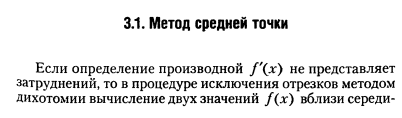
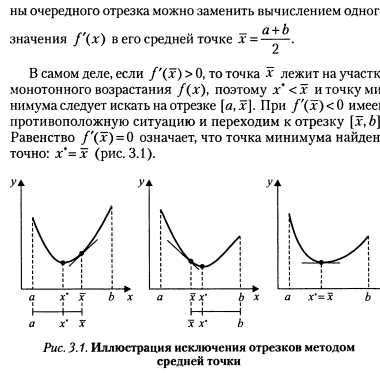

In [69]:
def midpoint_method(func, deriv, a, b, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    k = 0
    
    interval = b - a
    
    while interval > eps:
        x = (a + b) / 2
        dfunc_x = deriv(x)
        callback(x, func(x))
        if dfunc_x > 0:
            b = x
        else:
            a = x
        interval /= 2
        k += 1
    return x, k

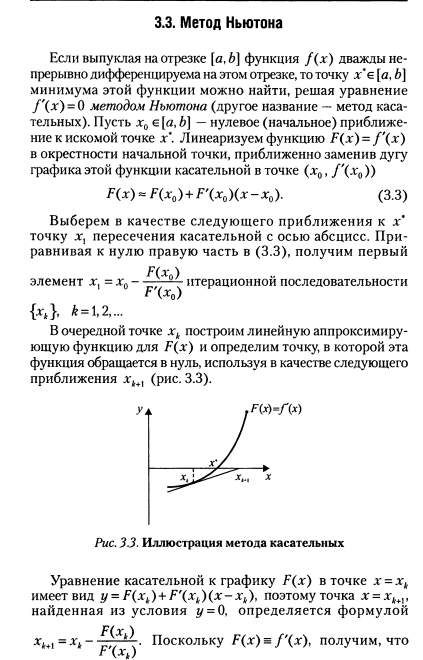
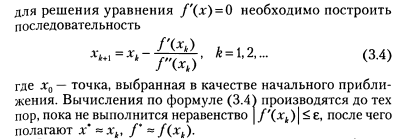

In [70]:
def newton_method(func, dfunc, d2func, x, eps, max_iter=100_000, callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        d2func_x_inv = 1 / d2func(x) 
        d = -d2func_x_inv * dfunc_x
        x_prev = x
        x = x + d
        
        if np.all(abs(x - x_prev) < eps):
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

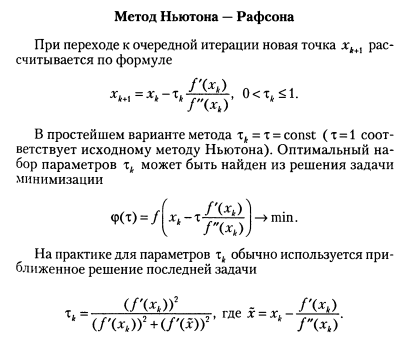

In [71]:
def newton_raphson_method(func, dfunc, d2func, x, eps, lr=1.0,
                          n_eps=0.01, max_iter=100_000,
                          callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    def fi(t, x, d):
        nonlocal func
        return func(x + t * d)

    def dfi(t, x, d):
        nonlocal dfunc
        return dfunc(x + t * d)

    def d2fi(t, x, d):
        nonlocal d2func
        return d2func(x + t * d)
    k = 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        
        d2func_x_inv = 1 / d2func(x)
        d = -d2func_x_inv * dfunc_x 
        fi_x_d = partial(fi, x=x, d=d)
        dfi_x_d = partial(dfi, x=x, d=d)
        d2fi_x_d = partial(d2fi, x=x, d=d)

        t, _ = newton_method(fi_x_d, dfi_x_d, d2fi_x_d, lr, n_eps, max_iter=1)
        x_prev = x
        func_x_prev = func(x)
        x = x + d
        func_x = func(x)
        if np.abs(x - x_prev) < eps:
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

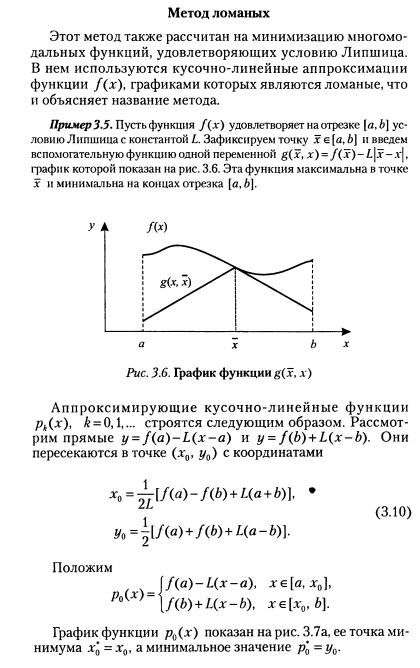
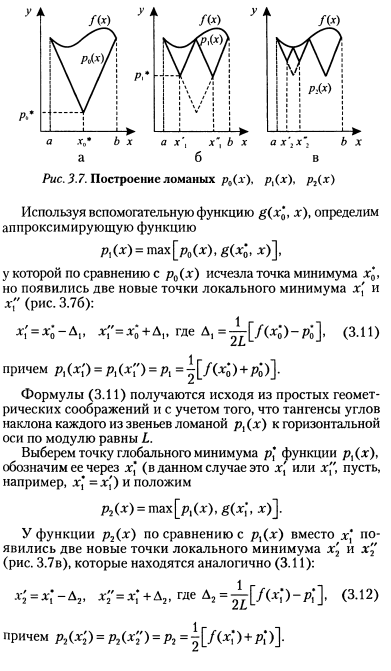


In [72]:
def polyline_method(func, dfunc, a, b, eps, callback=None):
    if callback is None:
        callback = lambda c, v: 0
        
    # L = max(np.abs(dfunc(np.linspace(lower_bound, upper_bound, 1000))))
    def abs_neg_dfunc(x):
        return -np.abs(dfunc(x))
    
    x_min, k = fibonacci_method(abs_neg_dfunc, a, b, 0.001, 0.0005)
    #print(f'number of eval in fib: {3 + k}')
    L = np.abs(dfunc(x_min))
    
    k = 0
    func_eval = 0

    func_a = func(a)
    func_b = func(b)
    x = 1 / 2 / L * (func_a - func_b + L * (a + b))
    p = 0.5 * (func_a + func_b + L * (a - b))
    
    callback(x, func(x))

    d = 1 / 2 / L * (f(x) - p)
    while 2 * L * d > eps:
        callback(x, func(x))
        x1 = x - d
        x2 = x + d

        func_eval += 2
        func_x1 = func(x1)
        func_x2 = func(x2)
        if func_x1 < func_x2:
            x = x1
            func_x = func_x1
        else:
            x = x2
            func_x = func_x2
        p = 0.5 * (func_x + p)
        d = 0.5 / L * (func_x - p)
        k += 1
    callback(x, func(x))
    return x, k

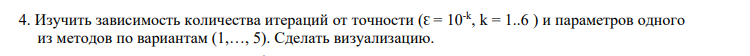

In [73]:
iter_number = {'radix_method': [], 'fibonacci_method': [], 'midpoint_method': [], 'newton_raphson_method': [], 'polyline_method': []}
lower_bound = 0
upper_bound = 1
x0 = 0.2
for k in range(1, 6 + 1):
    eps = 10**(-k)
    iter_number['radix_method'].append(bitwise_method(func, lower_bound, upper_bound, 180*2*k, eps)[1])
    iter_number['fibonacci_method'].append(fibonacci_method(func, a=0.1, b=1, interval_length=eps, eps=eps/2)[1])
    iter_number['midpoint_method'].append(midpoint_method(func, deriv1, lower_bound, upper_bound, eps)[1])
    iter_number['newton_raphson_method'].append(newton_raphson_method(func, deriv1, deriv2, x0, eps)[1])
    iter_number['polyline_method'].append(polyline_method(func, deriv1, lower_bound, upper_bound, eps)[1])

In [74]:
results = pd.DataFrame(iter_number)
results.index = range(1,7,1)
results

# iter_number

,radix_method,fibonacci_method,midpoint_method,newton_raphson_method,polyline_method
1,299,4,4,4,3
2,595,9,7,5,6
3,893,13,10,5,10
4,1198,18,14,6,13
5,1516,23,17,6,16
6,2187,28,20,6,20


### Графики кол-ва итераций от точности

<AxesSubplot:>

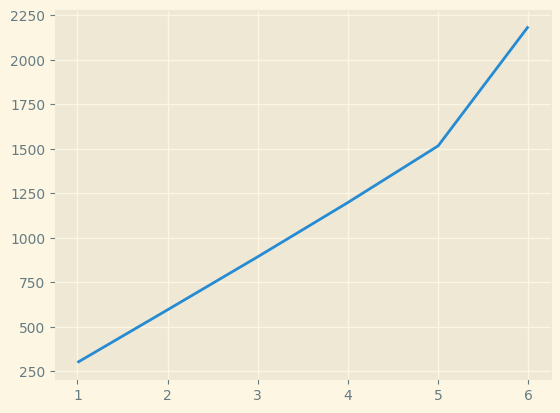

In [75]:
results['radix_method'].plot()

In [76]:
list(results)

['radix_method',
 'fibonacci_method',
 'midpoint_method',
 'newton_raphson_method',
 'polyline_method']

<AxesSubplot:>

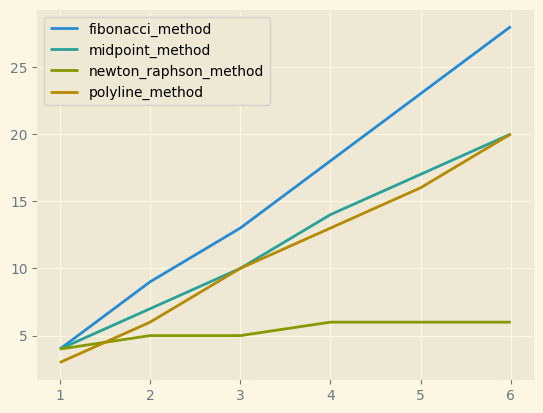

In [77]:
results[list(results)[1:]].plot()

### Визуализация траектории решения

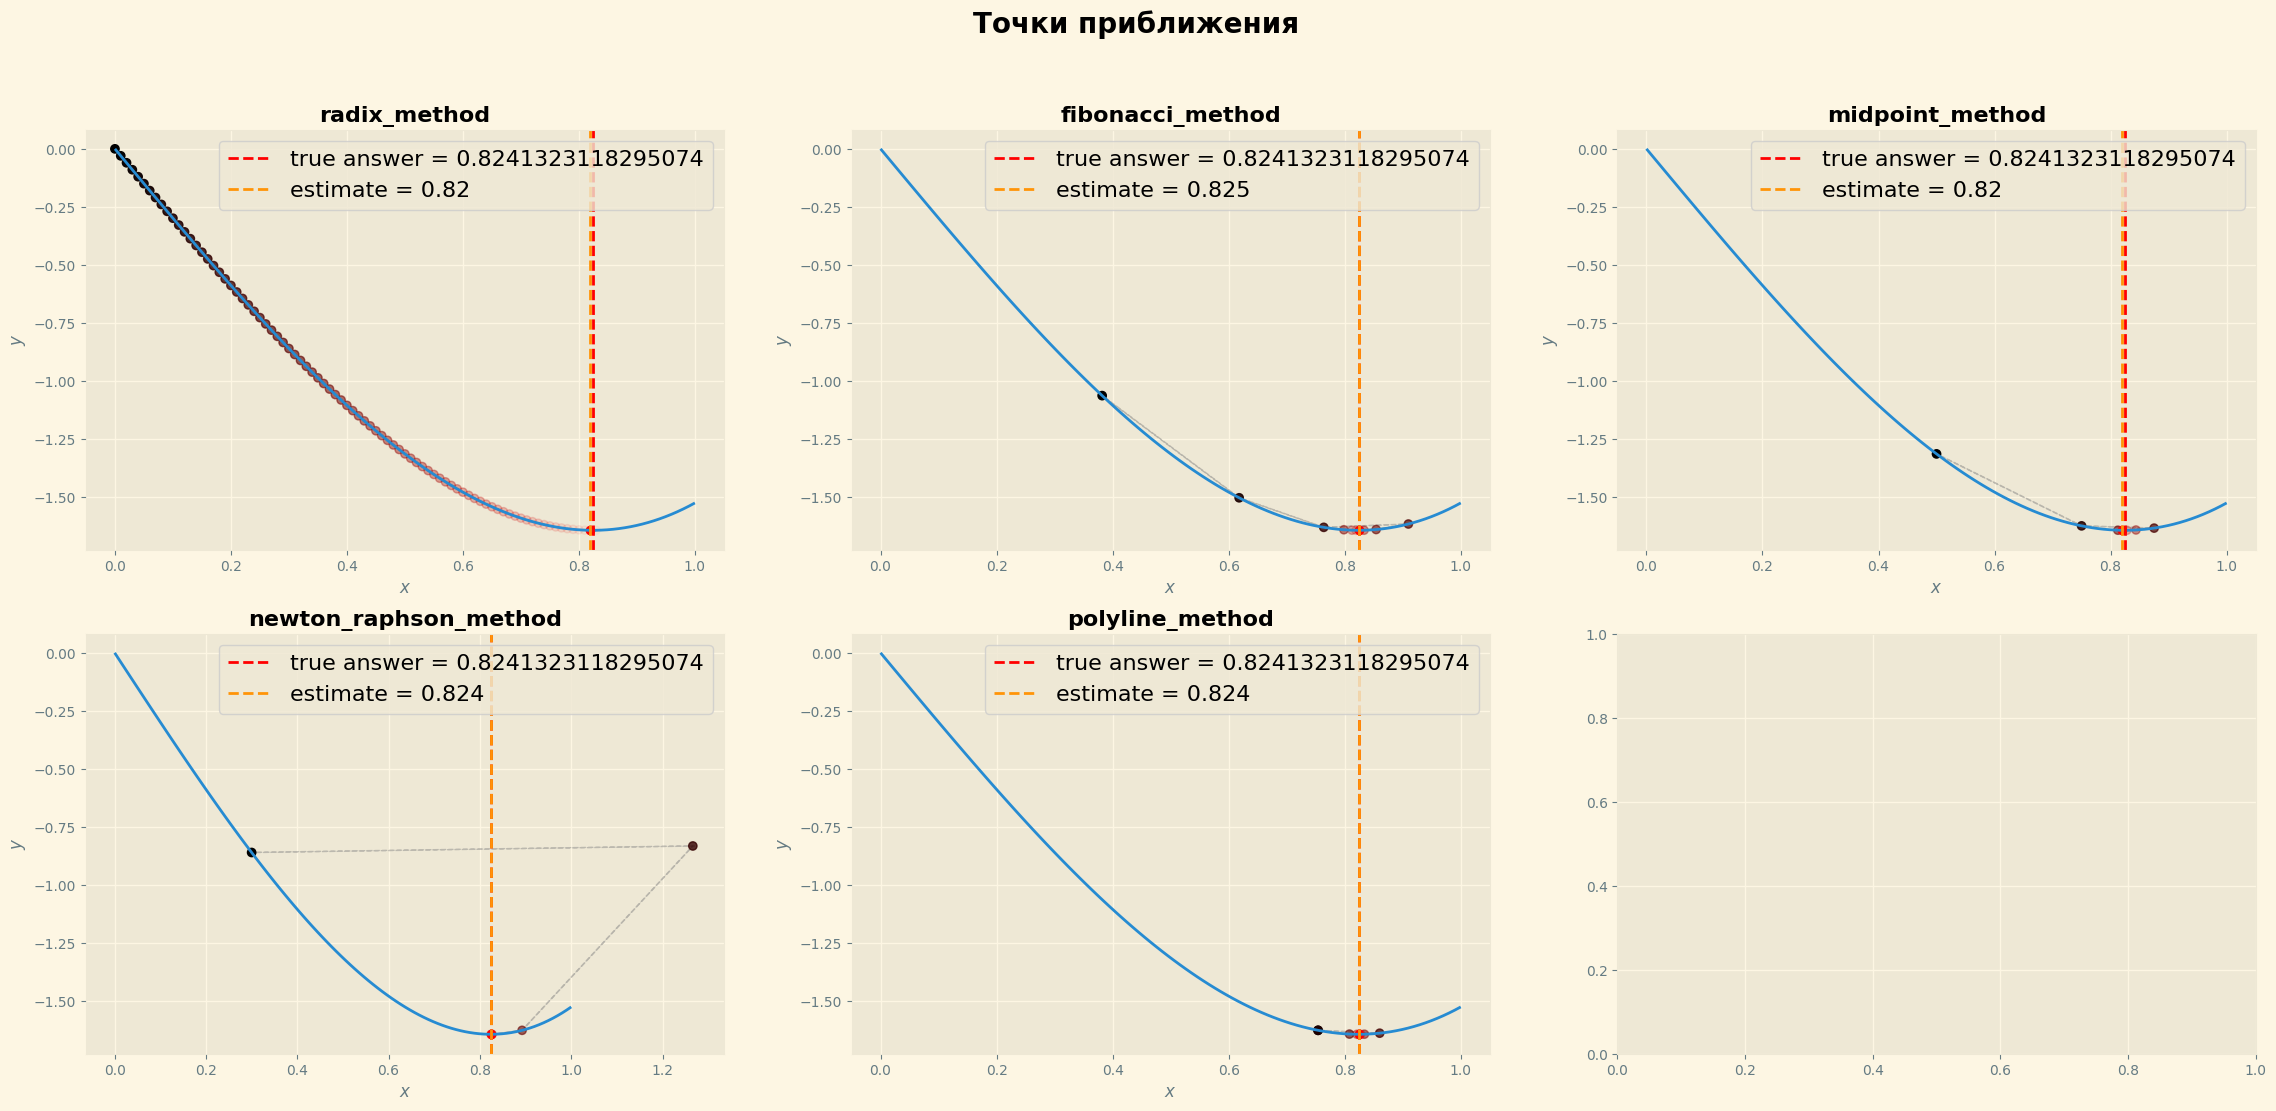

In [78]:
eps = 10**-2
fig, axes = plt.subplots(2,3, figsize=(28, 12))
fig.suptitle("Точки приближения", fontweight="bold", fontsize=20)
grid = np.linspace(lower_bound, upper_bound, 100)


callback = LoggingCallback()  # Не забываем про логирование
bitwise_method(func, lower_bound, upper_bound, 100, eps, callback=callback)
plotting(axes, 0, minimum.x[0],'radix_method')

callback = LoggingCallback()
fibonacci_method(func, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
plotting(axes, 1, minimum.x[0],'fibonacci_method')

callback = LoggingCallback()
midpoint_method(func, deriv1, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 2, minimum.x[0],'midpoint_method')

callback = LoggingCallback()
newton_raphson_method(func, deriv1, deriv2, 0.3, eps, callback=callback)
plotting(axes, 3, minimum.x[0],'newton_raphson_method')

callback = LoggingCallback()
polyline_method(func, deriv1, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 4, minimum.x[0],'polyline_method')

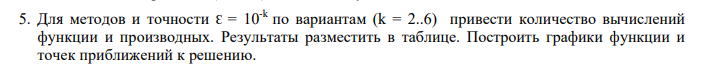

In [79]:
eps = 10**-2
lower_bound = 0
upper_bound = 1
names = ['func', 'deriv1', 'deriv2']

In [80]:
counts_iter = list(results.iloc[1])
counts_iter

eval_number = {'radix_method': [3 + counts_iter[0], 0, 0],
               'fibonacci_method': [3 + counts_iter[1], 0, 0],
               'midpoint_method': [0, counts_iter[2], 0],
               'newton_raphson_method': [0, 2 * counts_iter[3], 2 * counts_iter[3]],
               'polyline_method': [2 + 2 * counts_iter[4], 17, 0]}

eval_number_df = pd.DataFrame(eval_number)
eval_number_df.index = names
eval_number_df.T

,func,deriv1,deriv2
radix_method,598,0,0
fibonacci_method,12,0,0
midpoint_method,0,7,0
newton_raphson_method,0,10,10
polyline_method,14,17,0


In [81]:
[bitwise_method(func, lower_bound, upper_bound, 100, eps)[0],
fibonacci_method(func, a=0.1, b=1, interval_length=eps, eps=eps/2)[0],
midpoint_method(func, deriv1, lower_bound, upper_bound, eps)[0],
newton_raphson_method(func, deriv1, deriv2, x0, eps)[0],
polyline_method(func, deriv1, lower_bound, upper_bound, eps)[0],
minimum.x[0]]

[0.8150000000000005,
 0.8243750000000001,
 0.8203125,
 0.8241323352972675,
 0.8242874768836322,
 0.8241323118295074]

In [82]:
[abs(bitwise_method(func, lower_bound, upper_bound, 100, eps)[0] - minimum.x[0]) > eps,
abs(fibonacci_method(func, a=0.1, b=1, interval_length=eps, eps=eps/2)[0] - minimum.x[0]) > eps,
abs(midpoint_method(func, deriv1, lower_bound, upper_bound, eps)[0] - minimum.x[0]) > eps,
abs(newton_raphson_method(func, deriv1, deriv2, x0, eps)[0] - minimum.x[0]) > eps,
abs(polyline_method(func, deriv1, lower_bound, upper_bound, eps)[0] - minimum.x[0]) > eps]

[False, False, False, False, False]

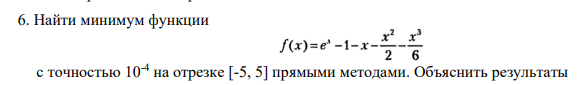

In [83]:
lower_bound = -5
upper_bound = 5
eps = 10**-4

In [84]:
def f2(x):
    return np.exp(x) - 1 - x - x**2/2 - x**3/6
    
def deriv1f2(x):
    return np.exp(x) - 1 - x - x**2/2

def deriv2f2(x):
    return np.exp(x) - 1 - x

### Результат встроенными методами

In [85]:
minimum = scipy.optimize.minimize(f2,method = 'Powell',bounds=scipy.optimize.Bounds(lower_bound,upper_bound),x0=0.2)
minimum

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5.020905277629918e-17
       x: [-2.415e-05]
     nit: 4
   direc: [[ 5.418e-05]]
    nfev: 207

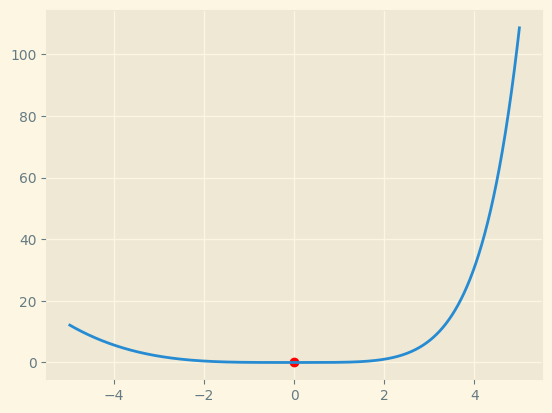

In [86]:
x = np.arange(lower_bound, upper_bound, eps)
plt.plot(x, f2(x))
plt.scatter(minimum['x'], minimum['fun'], color = 'red')

### Результат написанными методами

In [87]:
bitwise_method(f2, lower_bound, upper_bound, 100, eps)

(-5.000000000285511e-05, 1052)

In [88]:
fibonacci_method(f2, a=lower_bound, b=upper_bound, interval_length=eps, eps=eps/2)

(0.00018975414562633557, 23)

In [89]:
def plotting(axes, i, answer, callback, grid, f, title):
    if axes is not None:
        ax = axes[np.unravel_index(i, shape=axes.shape)]
        x_steps = np.array(callback.x_steps)
        y_steps = np.array(callback.y_steps)
        plot_convergence_1d(
            f, x_steps, y_steps,
            ax, grid, title
        )
        ax.axvline(answer, 0, linestyle="--", c="red",
                    label=f"true answer = {answer}")
        ax.axvline(x_steps[-1], 0, linestyle="--", c="xkcd:tangerine",
                    label=f"estimate = {np.round(x_steps[-1], 3)}")
        ax.legend(fontsize=16)

In [90]:
# fig, axes = plt.subplots(1,2, figsize=(20, 6))
# grid = np.linspace(lower_bound, upper_bound, 100)

# callback = LoggingCallback()
# bitwise_method(f2, lower_bound, upper_bound, 180, eps, callback=callback)
# plotting(axes, 0, minimum.x[0], callback, grid, f2, 'radix_method')

# callback = LoggingCallback()
# fibonacci_method(f2, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
# plotting(axes, 1, minimum.x[0], callback, grid, f2, 'fibonacci_method')

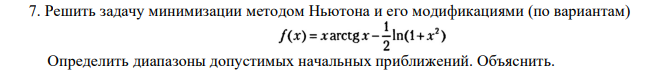

In [91]:
def f3(x):
    return x * np.arctan(x) - 0.5* np.log(1+x**2)

def deriv1f3(x):
    return np.arctan(x)

def deriv2f3(x):
    return 1 /(1 + x**2)

In [92]:
lower_bound = -2
upper_bound = 2
x0 = 1.356
eps = 10**-4

### Результат встроенными методами

In [93]:
minimum = scipy.optimize.minimize(f3,method = 'Powell',bounds=scipy.optimize.Bounds(lower_bound,upper_bound),x0=x0)
minimum

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.0814879110195774e-33
       x: [ 5.551e-17]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 14

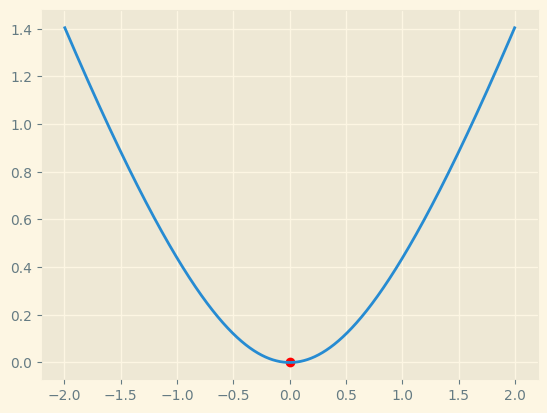

In [94]:
x = np.arange(lower_bound, upper_bound, eps)
plt.plot(x, f3(x))
plt.scatter(minimum['x'], minimum['fun'], color = 'red')

Так как функция симметричка, то решение будет сходиться, если x1 < -x0

Иначе говоря, границами будут являтся нули следующей функции:
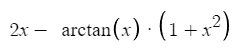
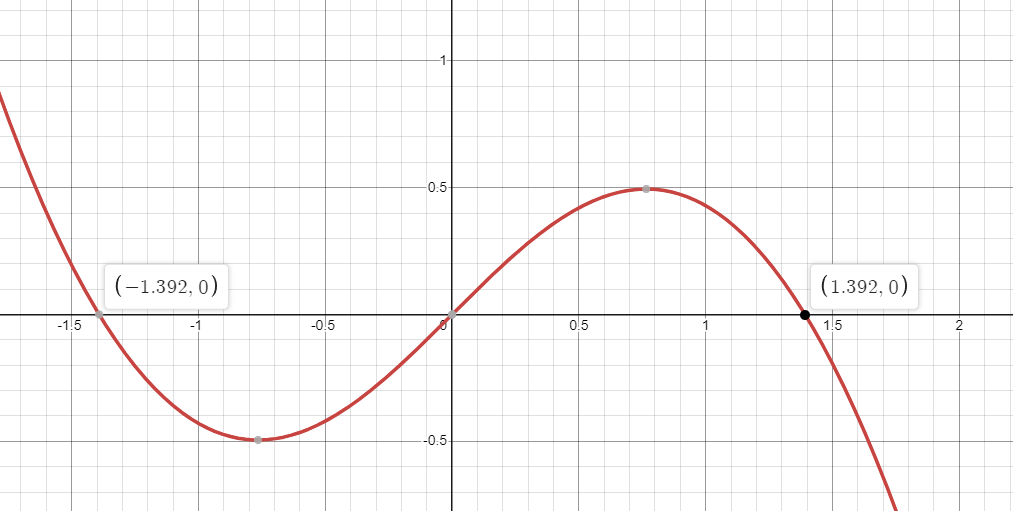

### Результат написанными методами

In [95]:
newton_raphson_method(f3, deriv1f3, deriv2f3, x0, eps, eps)

(-8.887252641708726e-15, 7)

In [96]:
newton_method(f3, deriv1f3, deriv2f3, x0, eps)

(-8.887252641708726e-15, 7)

In [97]:
# fig, axes = plt.subplots(figsize=(10, 6))
# grid = np.linspace(lower_bound, upper_bound, 100)

# callback = LoggingCallback()
# newton_raphson_method(f3, deriv1f3, deriv2f3, x0, eps, eps, callback = callback)
# plotting(np.array(axes), 0, minimum.x[0], callback, grid, f3, 'newton_raphson_method')

## Вывод:
Исследование методов одномерной минимизации показало, что проще всего и
лучше использовать встроенные в матпакеты методы, потому что они уже
написаны. Однако, анализируя всё же эти методы, то самым оптимальным
получился метод средней точки относительно количества итераций и вычислений, а
также простоты реализации. Если особенно важно добиться надежной и
устойчивой работы алгоритма, то целесообразно использовать поразрядного
поиска как одного из самых стабильных прямых методов.
Что касается метода ньютона и его модификаций, то он является самым быстросходящимся.
Метод ломанных самый труднореализуемый и имеет дополнительные условия, но его можно использовать для полимодальных функций.